In [1]:
#num objects:

In [3]:
import torch

In [4]:
import torch.distributions as dist
import pandas as pd
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [5]:
import numpy as np

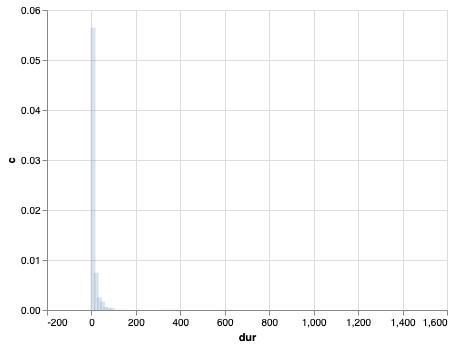

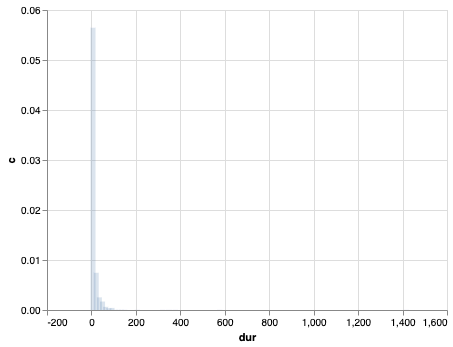

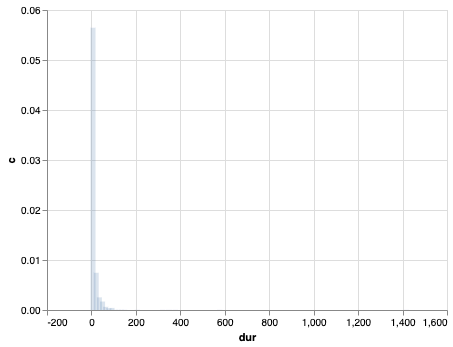

In [9]:
durHist, durBin = np.histogram(dur, bins=100, density=True)
cbin = (durBin[1:] + durBin[:-1])/2
durdf = pd.DataFrame({'c':durHist, 'dur':cbin})
alt.Chart(durdf).mark_bar(opacity=0.2).encode(x='dur', y='c')

In [5]:
#ddf2 = pd.read_parquet('estimator_sim_res.parquet')

In [8]:
#ddf2= ddf2.assign(est=ddf2.N1/ddf2.n)

In [60]:
(h,x) = np.histogram(np.log10(dur.numpy()), bins=40)

In [191]:
np.quantile(dur, [.01, .5, .9, .99])

array([   1.87254163,   45.16300392,  253.35154266, 1341.05460449])

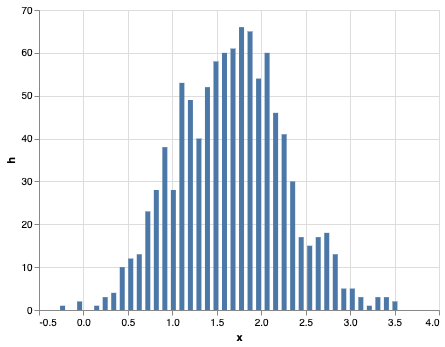

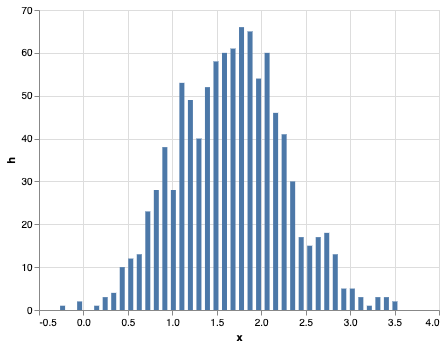

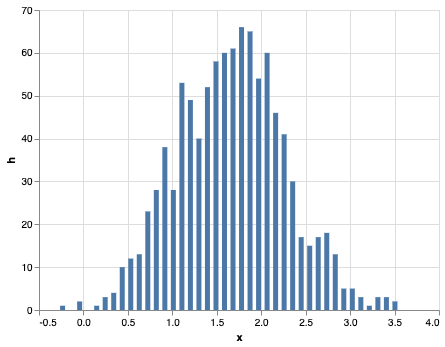

In [61]:
alt.Chart(pd.DataFrame({'x':x[1:], 'h':h})).mark_bar().encode(x='x', y='h')

In [297]:
ddf2[ddf2.n == 76000].N1.describe()

count    537.000000
mean       9.623836
std        2.628069
min        3.000000
25%        8.000000
50%       10.000000
75%       11.000000
max       18.000000
Name: N1, dtype: float64

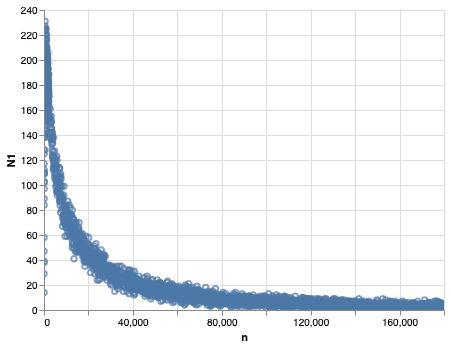

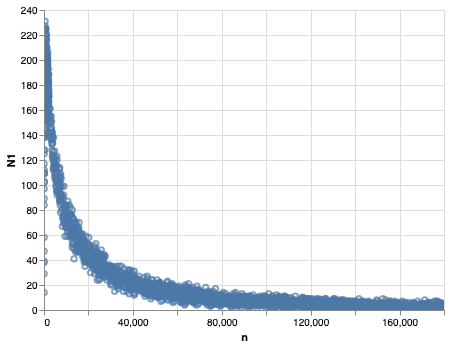

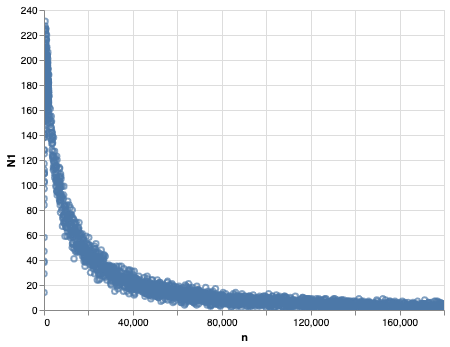

In [317]:
ddf2 = ddf#.assign()
alt.Chart(ddf.sample(3000)).mark_point().encode(x='n', y='N1').interactive()

In [477]:
examples100 = ddf2[ddf2.n.between(1,100)].sample(3)
examples1k = ddf2[ddf2.n.between(150,1000)].sample(2)
examplesM1 = ddf2[ddf2.n.between(5000, 100000)].sample(3)
examplesM2 = ddf2[ddf2.n.between(120000, 160000)].sample(2)
examplesG = ddf2[ddf2.n.gt(179000) & (ddf2.N1 == 0)].sample(1)
examplesG2 = ddf2[ddf2.n.gt(170000) & (ddf2.N1 > 0)].sample(1)
#examplesgt = ddf2[ddf2.n > 20000].sample(5)

In [478]:
examples = pd.concat([examples100, examples1k, examplesM1, examplesM2, examplesG, examplesG2])

In [479]:
examples = examples.sort_values('n').reset_index(drop=True)

In [533]:
def get_histogram(ddf, N1, n, min_q=0., max_q=1., alpha=.1, beta=1.):
    dddf = ddf
    qs = np.quantile(dddf.E,[min_q,max_q], interpolation='nearest')

    a = N1
    b = n        
    da = dist.Gamma(concentration=a, rate=b)
    db = dist.Gamma(concentration=a+.1, rate=b+1.)
    
    m1 = N1/n
    m2 = (N1+alpha)/(n+beta)
    mmin = min(m1,m2)
    mmax = max(m1,m2)
    
    var1 = N1/n**2
    var2 = (N1+alpha)/(n+beta)**2
    stdmax = np.sqrt(max(var1,var2))
    
    x_min = max(mmin - 2.5*stdmax,0)
    x_max = mmax + 2.5*stdmax
    
    dddf = dddf[(dddf.E >= qs[0])& (dddf.E <= qs[1])]    
    histE, bns = np.histogram(dddf.E, bins=100, density=True)
    xs = (bns[1:] + bns[:-1])/2.
    widths = bns[1:] - bns[:-1] 
    
    xmmin = min(x_min, xs.min())
    xmmax = max(x_max, xs.max())
    dx = np.arange(xmmin, xmmax, (xmmax-xmmin)/201)
    pa = da.log_prob(torch.from_numpy(dx).view(-1,1)).exp().mean(dim=1).numpy()
    pb = db.log_prob(torch.from_numpy(dx).view(-1,1)).exp().mean(dim=1).numpy()
    thomson_samples = db.sample((pa.shape[0],)).numpy()

    # p_avg = d2.log_prob(torch.from_numpy(xs).view(-1,1)).exp().mean(dim=1).numpy()
    curves = pd.DataFrame({'density':pa, 'density2':pb, 'xs':dx, 'samples':thomson_samples, 'est':N1/n})
    hist = pd.DataFrame({'histogram':histE, 'xs':xs, 'widths':widths})
    #curves = curves.unstack().rename('p').reset_index()
    return curves, hist

127 82 4534


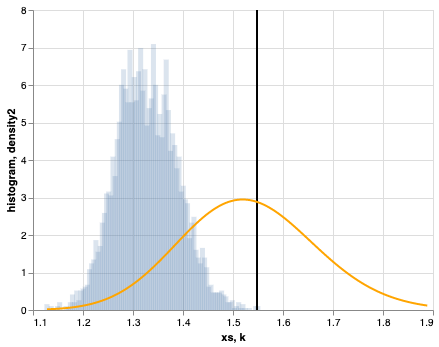

121 97 10549


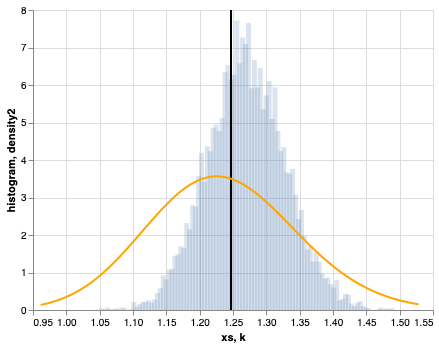

116 100 14073


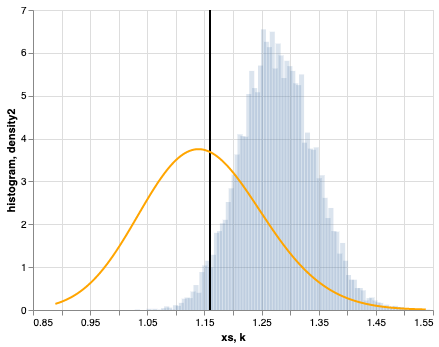

149 163 17602


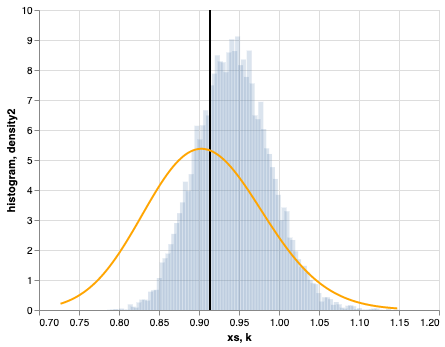

182 276 17361


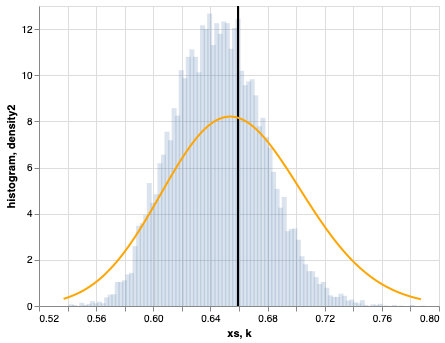

58 14093 8903


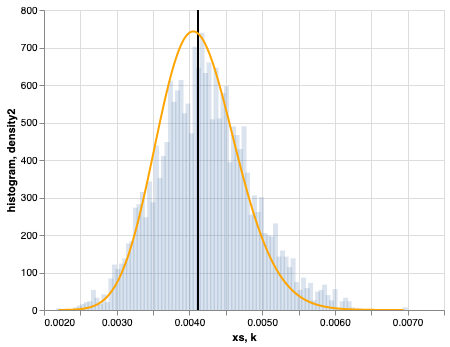

18 41013 11834


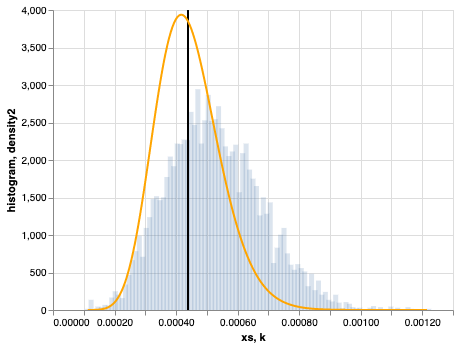

17 48094 15506


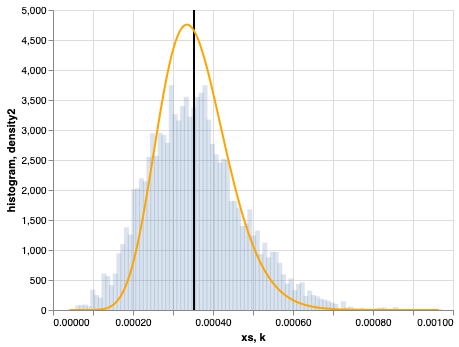

4 120911 23025


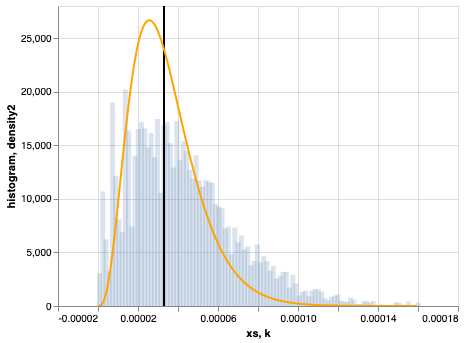

7 131315 14304


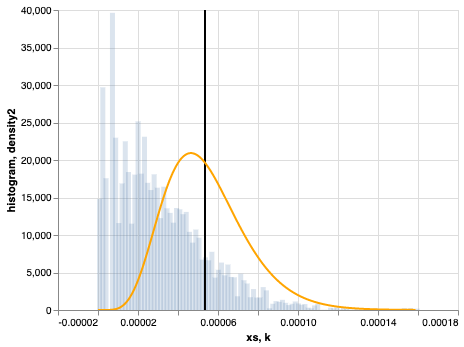

5 172085 11336


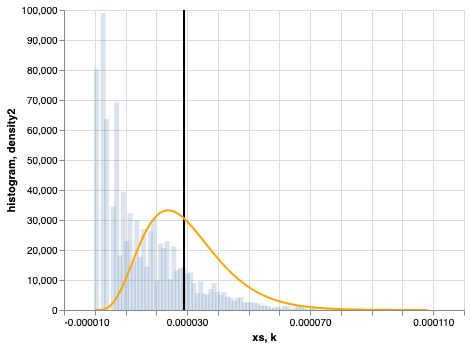

1e-06 179601 7648


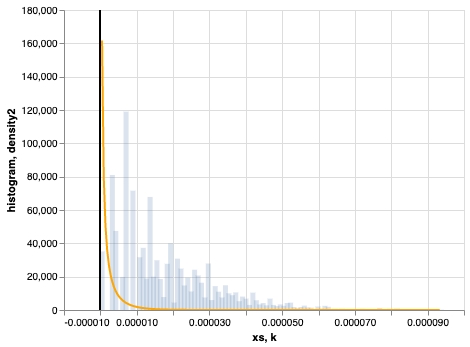

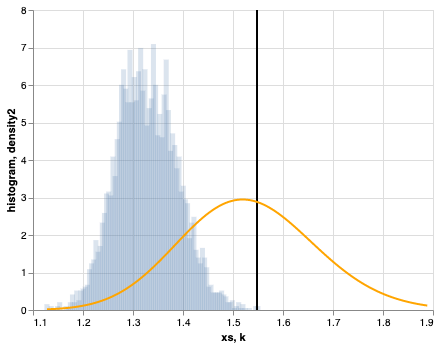

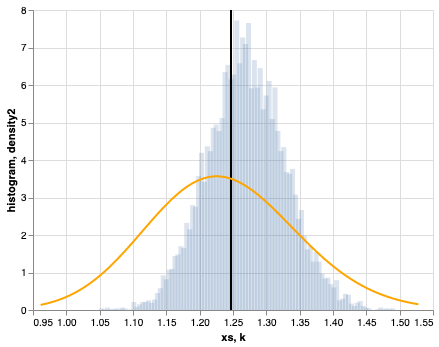

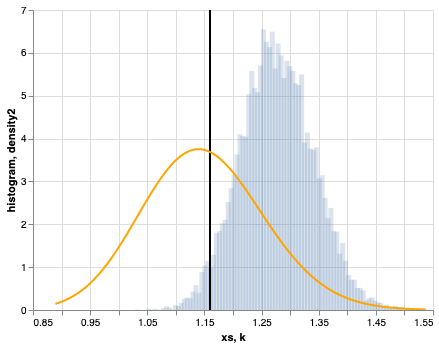

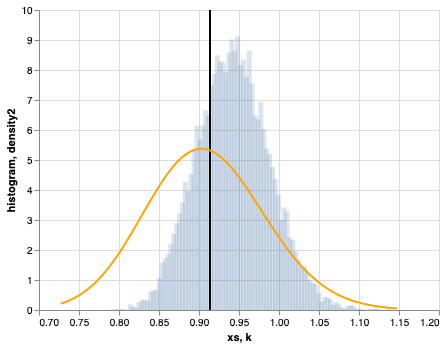

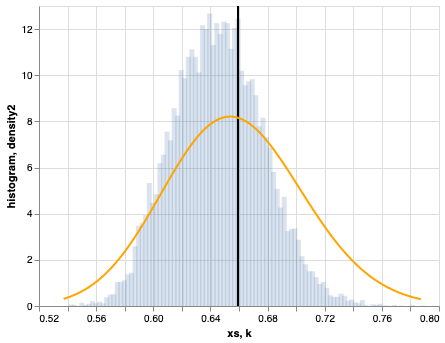

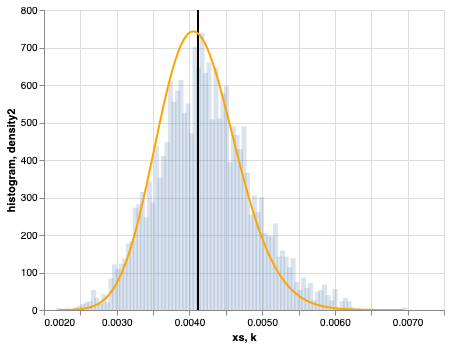

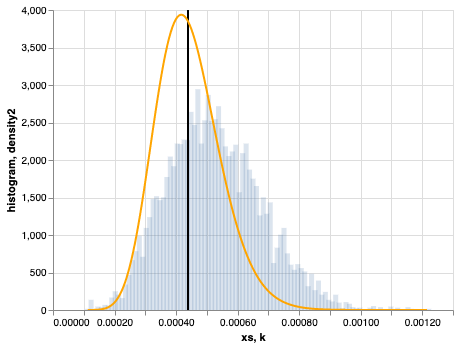

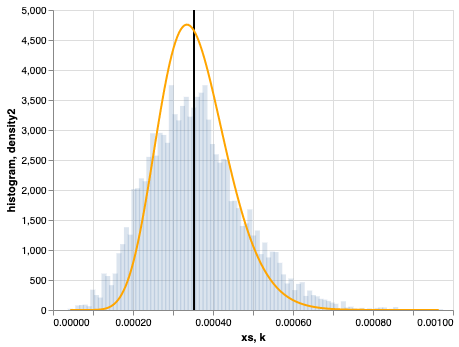

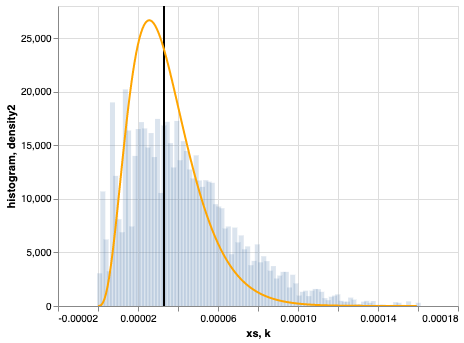

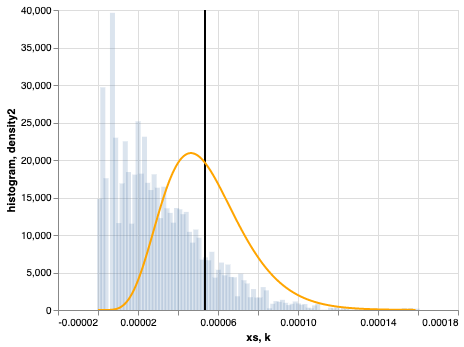

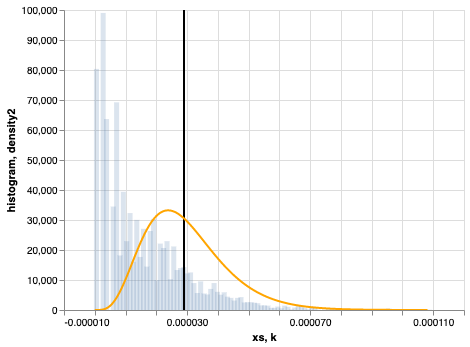

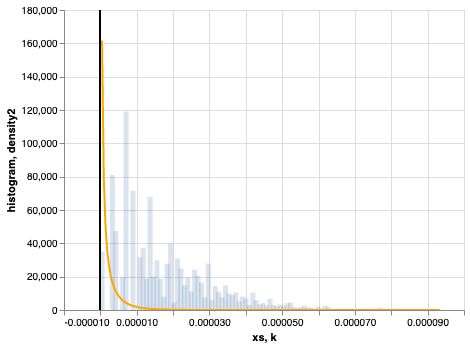

In [534]:
ex = examples

cvs = []
hs = []

for idx in range(ex.shape[0]):
    n = ex.n.iloc[idx]
    N1 = ex.N1.iloc[idx]
    N1orig = N1
    if N1 == 0:
        N1 = 1e-6

    if n < 100:
        fd = 5
    elif n < 2000:
        fd = 10
    else:
        fd = 30
        
    s1 = ddf2[ddf2.n.between(n-fd, n+fd) & ddf2.N1.between(N1-2, N1+2)]
    print(N1,n,s1.shape[0])
    cv1, h1 = get_histogram(s1, N1=N1, n=n, alpha=1.)
    base = alt.Chart(h1.assign(k=N1/n))
    base2 = alt.Chart(cv1)
    
    p = (base.mark_bar(opacity=0.2).encode(x='xs', y='histogram')
    + base.mark_rule().encode(x='k')     
    + base2.mark_line(color='orange').encode(x='xs', y='density2')
    
    )
    cvs.append(cv1.assign(n=n, N1=N1orig, i=idx))
    hs.append(h1.assign(n=n,N1=N1orig, i=idx))    
    
    display(p)

In [539]:
p = dur/F
mu = p.mean().item()
sigma = p.std().item()

In [541]:
dur.min(), dur.max(), np.median(dur)
dur.min(), dur.max(), np.median(dur)

(tensor(2.9665), tensor(140917.8281), 1001.3563)

In [549]:
mu, sigma

(0.0032829204574227333, 0.008782008662819862)

In [544]:
p.min(), p.max()

(tensor(2.9665e-06), tensor(0.1409))

In [554]:
np.median(p), np.quantile(p, [.1, .90])

(0.0010013564, array([0.00011671, 0.00732243]))

In [556]:
dur.max()/30/60/60

tensor(1.3048)

In [516]:
np.sqrt(N)*(mu + sigma)

tensor(0.3815)

In [538]:
cvdf.tail(n=10)

,density,density2,xs,samples,est,n,N1,i
2403,1.254854e-09,0.000174,0.000089,2.689478e-07,5.567898e-12,179601,0,11
2404,1.147971e-09,0.000159,0.000090,1.882881e-07,5.567898e-12,179601,0,11
2405,1.050219e-09,0.000146,0.000090,8.296737e-06,5.567898e-12,179601,0,11
2406,9.608172e-10,0.000133,0.000091,4.355201e-15,5.567898e-12,179601,0,11
2407,8.790490e-10,0.000122,0.000091,1.602815e-07,5.567898e-12,179601,0,11
2408,8.042595e-10,0.000112,0.000091,1.632190e-11,5.567898e-12,179601,0,11
2409,7.358541e-10,0.000102,0.000092,7.367832e-10,5.567898e-12,179601,0,11
2410,6.732836e-10,0.000094,0.000092,1.240174e-08,5.567898e-12,179601,0,11
2411,6.160488e-10,0.000086,0.000093,1.466346e-13,5.567898e-12,179601,0,11
2412,5.636934e-10,0.000079,0.000093,6.231447e-13,5.567898e-12,179601,0,11


In [509]:
q1 = mu.pow(2) + sigma_sq
q2 = dur2.pow(2).mean()

In [510]:
(q1-q2)/(q2)

tensor(0.0164, dtype=torch.float64)

In [535]:
cvdf = pd.concat(cvs, ignore_index=True)
hdf = pd.concat(hs, ignore_index=True)

In [536]:
cvdf.to_csv('cvdf.csv', index=False)
hdf.to_csv('hdf.csv', index=False)

In [537]:
cvdf.groupby(['n', 'N1']).size()

n       N1 
82      127    201
97      121    201
100     116    201
163     149    202
276     182    201
14093   58     201
41013   18     201
48094   17     201
120911  4      201
131315  7      201
172085  5      201
179601  0      201
dtype: int64

In [410]:
# empirical validation

In this section we show a visual validation of our estimates from the previous section. The question we are interested in is: given an observed N1, and n, what is the  true expected R(n+1), and how does it compare to our belief distribution $\Gamma(N1,n)$. 

In order to do this we ran a series of simulation experiments.
We first generate 1000 $p_0,p_1,...p_1000$ at random to represent 1000 instances with different durations. To be consistent with the duration skew we observe in real data, we use a lognormal distribution. For example, in our simulation, the  duration quantile .01 is 10 frames, while quantile .99 is 13000 frames, and the median is 450 frames, the $p_i$ is then computed by assuming a duration over 1 million frames. 

Then, we model the sampling of a random frame as follows: each instance is in the frame independently at random with probablity $p_i$. To decided which instances will show up in our frame we simulate tossing 1000 coins each with their own $p_i$, and the positive draws give us the subset of instances visible in that frame. We then proceed sequentially sampling `frames' this way,  tracking how many frames we have sampled $n$, and which of the instances we have already seen. We use this to compute how many instances we have seen exactly once, $N_1$, and we also record the expected $\text{E}\left[R(n+1)\right]$: the expected number of new instances in a new frame sampled.  We can do this in our simulation because we can track the unknown instances and know their hidden probabilities $p_i$, so we compute $\text{E}\left[R(n+1)\right] = \sum_{i \in \text{Unseen}(n)} p_i$. Note this is different than the actual observed number of new results, $R(n+1)$ which is much more variable.  We sequentially sample frames up to n=300000, and repeated the experiment 3000 times, obtaining hundreds of millions of tuples of the form $(n, N1, R(n+1))$ for our fixed set of $p_i$.   Using this data, we can answer our question by selecting different observed $n$ and $N1$ and conditioning (filtering) on them, then plotting a histogram of the actual $R(n+1)$ that ocurred in our simulations. We show these histograms for 6 different randomly chosen pairs of $n$ and $N1$ in \autoref{fig:estimate}, alongside our belief distribution.

In [123]:
ddf2[ddf2.n.between(200000-50,200000+50)].N1.describe()

count    30000.000000
mean        82.156700
std          7.742214
min         59.000000
25%         77.000000
50%         82.000000
75%         87.000000
max        108.000000
Name: N1, dtype: float64

In [129]:
s1 = ddf2[ddf2.n.between(200000-50,200000+50) & ddf2.N1.between(65-4,70+4)] # 4k
s2 = ddf2[ddf2.n.between(200000-50,200000+50) & ddf2.N1.between(100-4,100+4)]
#.N1.describe()

In [130]:
s1.shape, s2.shape

((4875, 6), (1258, 6))

In [133]:
cd1 = get_histogram(s1)
cd2 = get_histogram(s2)

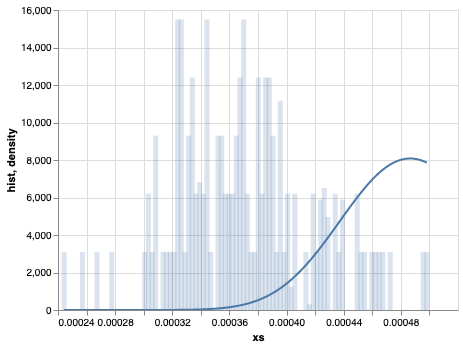

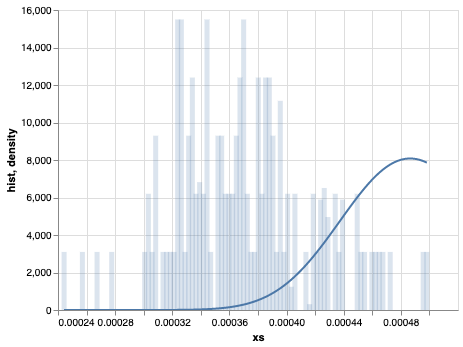

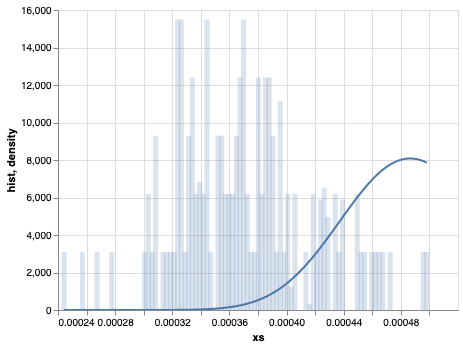

In [136]:
base = alt.Chart(cd2)
(base.mark_bar(opacity=0.2).encode(x='xs', y='hist')
+ base.mark_line().encode(x='xs', y='density')
)

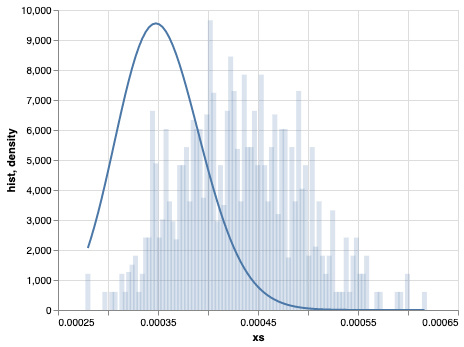

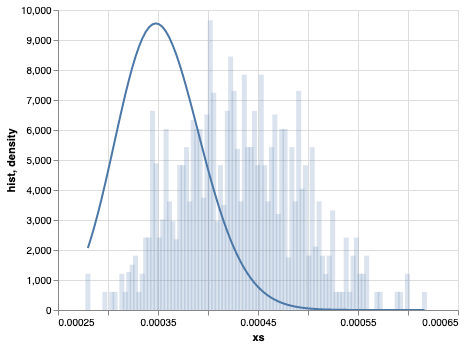

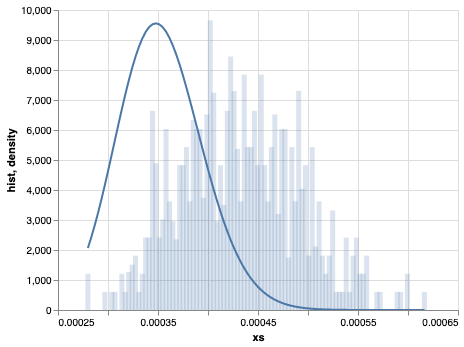

In [135]:
base = alt.Chart(cd1)
(base.mark_bar(opacity=0.2).encode(x='xs', y='hist')
+ base.mark_line().encode(x='xs', y='density')
)

In [109]:
cd3 = get_conditional(ddf2, nbounds=(24000-50,24000+50), N1bounds=(60-4,60+4))
cd2s = get_conditional(ddf2, nbounds=(500-10,500+10), N1bounds=(100-5,100+5), sample=1)
cd2b = get_conditional(ddf2, nbounds=(13000-50,13000+50), N1bounds=(100-5,100+5))

75000
63000
303000


In [97]:
cd30 = get_conditional(ddf2, nbounds=(290000-5,290000+5), N1bounds=(1,1))

9000


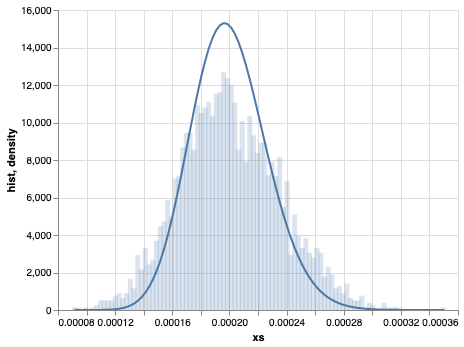

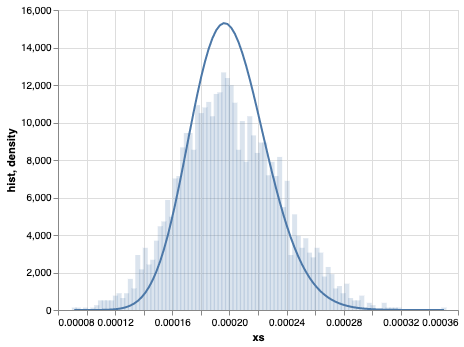

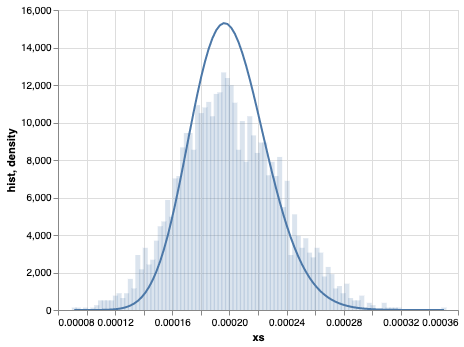

In [98]:
base = alt.Chart(cd30)
(base.mark_bar(opacity=0.2).encode(x='xs', y='hist')
+ base.mark_line().encode(x='xs', y='density')
)

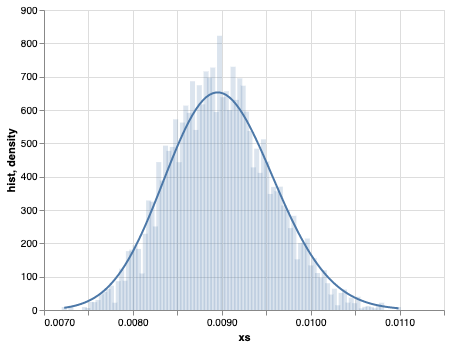

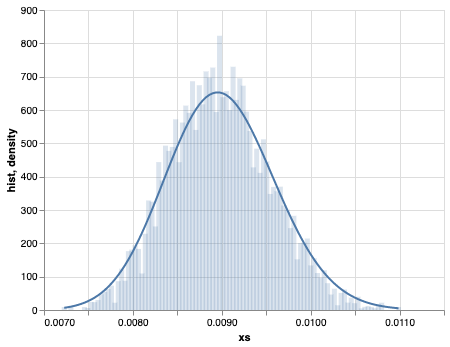

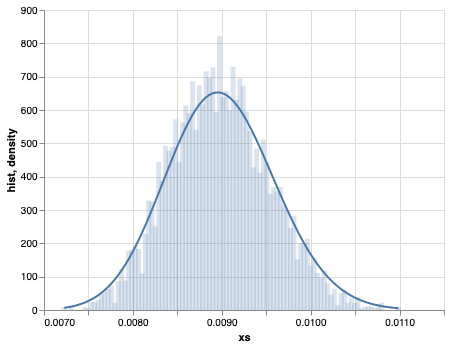

In [101]:
base = alt.Chart(cd3)
(base.mark_bar(opacity=0.2).encode(x='xs', y='hist')
+ base.mark_line().encode(x='xs', y='density'))

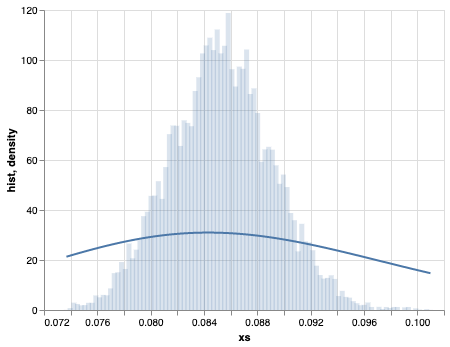

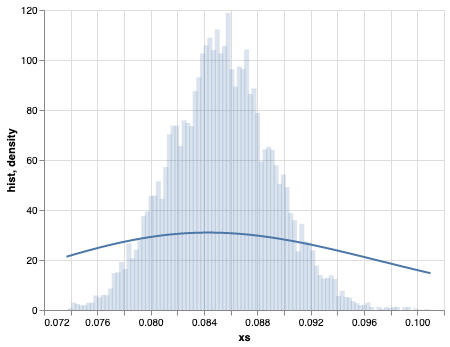

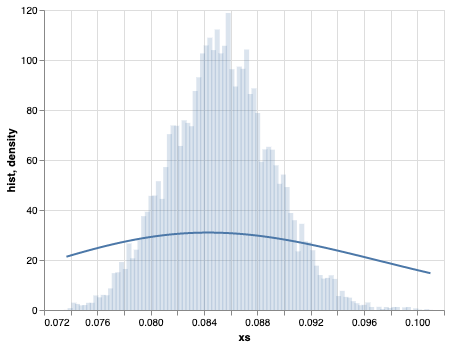

In [110]:
base = alt.Chart(cd2s)
(base.mark_bar(opacity=0.2).encode(x='xs', y='hist')
+ base.mark_line().encode(x='xs', y='density'))

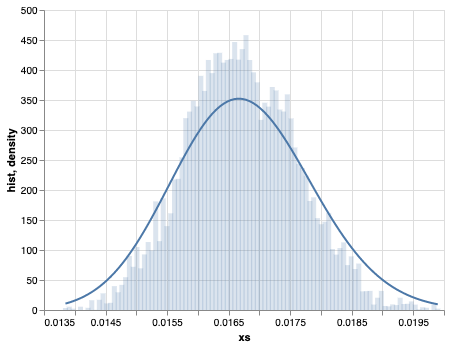

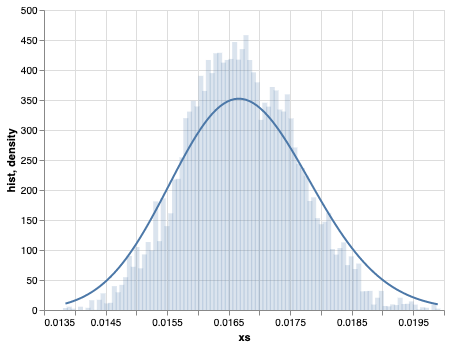

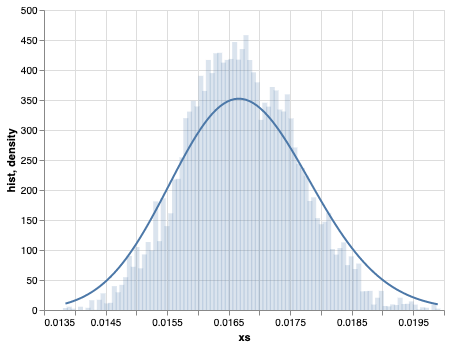

In [65]:
base = alt.Chart(cd2b)
(base.mark_bar(opacity=0.2).encode(x='xs', y='hist')
+ base.mark_line().encode(x='xs', y='density'))

In [244]:
N = 1000
F = 1000000
num_trials = 10000
dur = dist.LogNormal(1.5, 1.6).sample((N,))*200
pi = dur/F
frame_sampler = dist.Bernoulli(pi)
acc = torch.zeros((num_trials, N))
# dfs = []
data3 = []
i = 0

In [245]:
from tqdm.notebook import tqdm
durq = np.quantile(dur.numpy(), [.01,.5,.99])
durq/30, durq/F

(array([6.97123435e-01, 3.33785451e+01, 1.14142480e+03]),
 array([2.09137031e-05, 1.00135635e-03, 3.42427439e-02]))

In [242]:
actual_new.shape, mask.shape

(torch.Size([10000]), torch.Size([10000, 1000]))

In [313]:
max_n = 180000
start = i
for i in tqdm(range(start,max_n)): 
    samp = frame_sampler.sample((num_trials,))
    missing = (acc == 0)
    actual_new = (samp*missing.float()).sum(dim=1)
    expected_new = missing.float().mv(pi)
    N1 = (acc==1).sum(dim=1)
    sp = .5 if i < 2000 else .03
    mask = dist.Bernoulli(probs=sp).sample((num_trials,)).bool()
    acc += samp
    data3.append({'R':actual_new[mask].numpy(), 'E':expected_new[mask].numpy(), 'N1':N1[mask].numpy(), 'n':i})

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [314]:
dfs = []
for r in data3:
    df = pd.DataFrame(r)
    df = df.assign(t=df.index)
    dfs.append(df)

In [315]:
ddf= pd.concat(dfs, ignore_index=True)

In [316]:
ddf.to_parquet('ddf5.parquet')

In [270]:
# ddf[ddf.n == 10].shape

In [1377]:
# from tqdm.notebook import tqdm_notebook as tqdm
# data2 = []
# for t in tqdm(range(2000)):
#     acc = torch.zeros_like(frame_sampler.sample())
#     for i in range(7000):
#         samp = frame_sampler.sample()
#         missing = (acc == 0)
#         actual_new = samp[missing].sum()
#         expected_new = missing.float().dot(p)
#         N1 = (acc == 1).sum()
#         acc += samp
#         data2.append({'R':actual_new.item(), 'E':expected_new.item(), 'N1':N1.item(), 'n':i, 't':t})

In [263]:
ddf2 = ddf.assign(est=ddf.N1/ddf.n)

In [163]:
ddsamp = ddf.sample(n=5000)

In [164]:
x = ddsamp[~((ddsamp.E == 0) | (ddsamp.est == 0))]

In [1614]:
xmin = min(x.E.min(), x.est.min())
xmax = max(x.est.max(), x.E.max())

In [1615]:
vals = np.geomspace(xmin,xmax,num=5)
iddf = pd.DataFrame(dict(x=vals, y=vals))

In [165]:
xy = x[x.n > 0]
#xy.to_csv('est_sample.csv')

In [1795]:
%pwd

'/nvme_drive/orm/car_stuff/vroom_nbs'

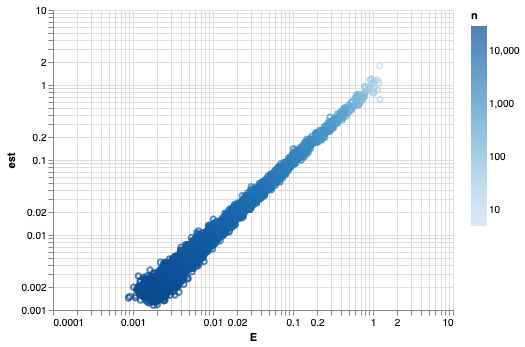

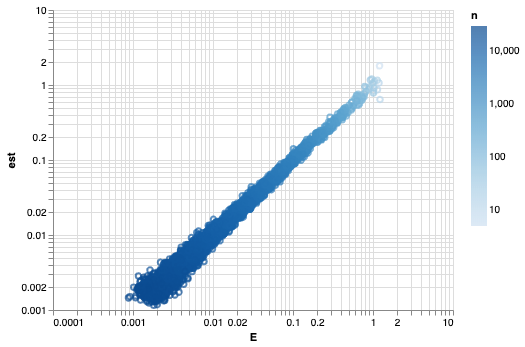

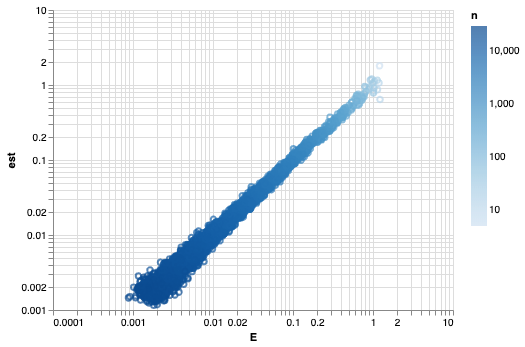

In [166]:
ch1 = alt.Chart(xy).mark_point().encode(alt.X('E', scale=alt.Scale(type='log')), 
                                      alt.Y('est', scale=alt.Scale(type='log')), color=alt.Color('n', scale=alt.Scale(type='log')))
ch1

In [1781]:
ddfs = ddf.sample(n=5000)

In [1793]:
#alt.Chart(ddfs[ddfs.N1 > 0]).mark_point().encode(x='n', y=alt.Y('N1', scale=alt.Scale(type='log'))).interactive()

In [1830]:
np.quantile(dddf.E, [.001, .999])

array([0.00033605, 0.00211298])

In [376]:
gd = dist.Gamma(140,100)

In [380]:
#gd.cdf(torch.arange(1.0, 2.0, .05))

In [1873]:
cs = []
for p in [.2, .002, .00002]:
    curves = get_conditional(ddf, estVal=p)
    curves=curves.assign(est=p)
    cs.append(curves)

In [1874]:
csdf = pd.concat(cs, ignore_index=True)

In [1875]:
csdf.to_csv('csdf.csv')



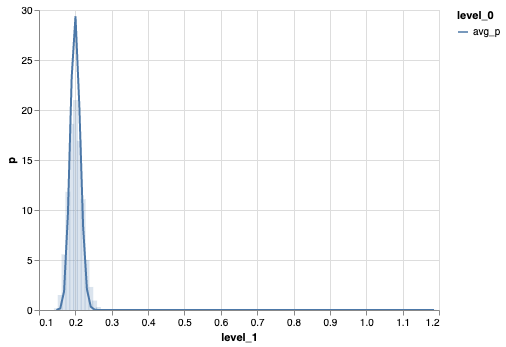

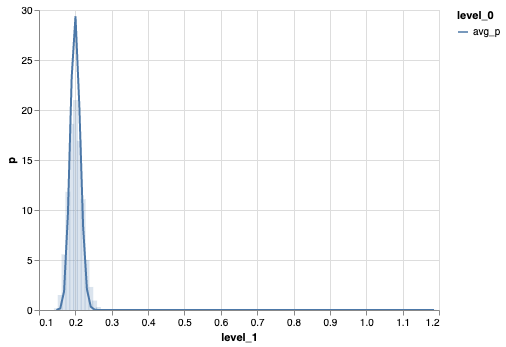

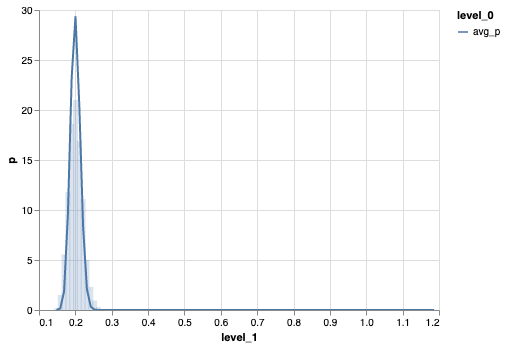

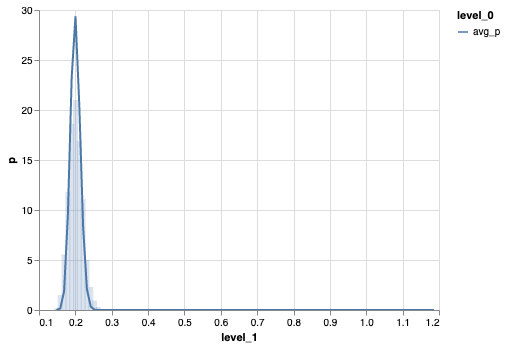

In [1804]:
(alt.Chart(curves[curves['level_0'] == 'hist']).mark_bar(opacity=0.2).encode(x='level_1', y='p')
+
alt.Chart(curves[curves['level_0'] != 'hist']).mark_line().encode(x='level_1', y='p', color='level_0:N'))

In [1877]:
# now  show desirable behaviors... higher frequency => higher sampling

In [ ]:
num_trials = 4000
max_n = 200001
#acc = torch.zeros(num_trials, p.shape[0])
#data3 = 
stop = i
for i in tqdm(range(stop,max_n)): 
    samp = frame_sampler.sample((num_trials,))
    missing = (acc == 0)
    actual_new = (samp*missing.float()).sum(dim=1)#.float())
    expected_new = missing.float().mv(p)
    N1 = (acc==1).sum(dim=1)
    acc += samp
    if i % 100 == 0:
        data3.append({'R':actual_new.numpy(), 'E':expected_new.numpy(), 'N1':N1.numpy(), 'n':i})

In [ ]:
choices = []
## get score
## sample one thing